# **Question 19**

QUESTION 19: In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?

> The VGG network is trained on a dataset with different classes as targets. Despite this, the features learned by the VGG Network are very abstract and hierarchical representations of the visual information. Lower layers of the network capture low level features such as edges and textures. The higher layers learn more complex and abstract features which are required for classification tasks. These features that are learned are generalizable and transferable over different datasets. This is the reason why the features derived from such a network have discriminative power for a custom dataset. This is because they encode relevant visual information that can be useful for other tasks. Also, transfer learning techniques can make use of these pre-trained features by fine tuning the network on a custom dataset thereby adapting new characteristics and learning from the custom dataset along with retaining information from the original dataset.

# **Question 20**

In [ ]:
#Importing the necessary libraries
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

!pip install torchvision

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE

from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

from sklearn.model_selection import train_test_split

!pip install umap_learn
import umap.umap_ as umap

from sklearn.cluster import AgglomerativeClustering

!pip install hdbscan
import hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.3 MB/s eta 0:00:00
  Created wheel for umap_learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=ef988d905c5e8b512703174540921a371b68b9ee9d25ab54b4b5ab7468ac6f32
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap_learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039285 sha256=51c410f98f62a8038d5914687cf9ae8201593846604c767a7892b8501fd315f9
  S

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:15<00:00, 36.7MB/s]
100%|██████████| 58/58 [00:33<00:00,  1.71it/s]


QUESTION 20: In a brief paragraph explain how the helper code base is performing feature extraction.

> The helper code first loads the flower photos dataset. We then transform the dataset by resizing, center cropping and normalization to ensure that the data is homogeneous. Then a batch size of 64 is set. We divide the entire dataset into batches each having a size of 64 samples. Then we call feature extract which loads the vgg16 model first. VGG016 has multiple feature layers which include ReLU, Conv2d and MaxPool2d. The image is converted into a one dimensional vector and the first part of the fully connected layer of VGG16 is extracted. The forward method takes an input and gives the feature vector as the output. The training is done in 58 epochs and we obtain 4096 features per sample.

# **Question 21**

In [ ]:
#Checking the shape
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


In [ ]:
#Checking the feature dimensions
feature_dimension = f_all.shape[1]
print(f"Dimension of Feature Vector: {feature_dimension}")

Dimension of Feature Vector: 4096


QUESTION 21: How many pixels are there in the original images? How many features does the VGG network extract per image; i.e what is the dimension of each feature vector for an image sample?

> The images of the dataset are of varied sizes. Hence, we have resized it to 224x224. We resize the image to a square shape of 224 pixels. We then do center crop which crops the image around the center creating a new image with the same dimensions. Together, resizing and center crop ensure that each input image is resized to a common size (224x224 pixels) and then cropped around its center to produce a consistent input size for the neural network. The VGG Network extracts 4096 features per image sample.

# **Question 22**

In [ ]:
#Loading vgg16
vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
#Checking the features of vgg
list(vgg.features)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

QUESTION 22: Are the extracted features dense or sparse? (Compare with sparse TF-IDF features in text.)

>The extracted features from VGG16 are dense, unlike sparse TF-IDF features commonly used in text data. We can find the density by counting the number of non zero entities they have. For TF-IDF, we see that we get a sparse matrix with many non zero elements. But, for VGG16, we notice that all the entities are non zero and hence it is denser as compared to TF-IDF. In summary, while VGG16 extracts dense feature representations for images, TF-IDF generates sparse feature representations for text. The choice between dense and sparse representations depends on the nature of the data and the requirements of the machine learning task.

# **Question 23**

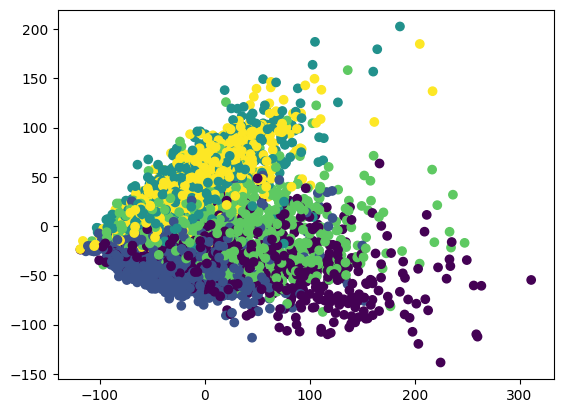

In [ ]:
#Plot for PCA
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

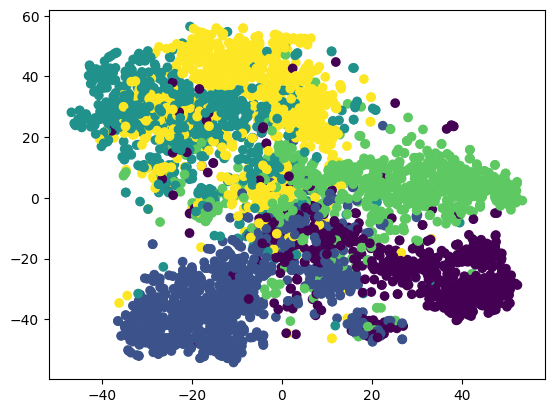

In [ ]:
#Plot for TSNE
dim_red = TSNE(n_components=2).fit_transform(f_all)
plt.scatter(*dim_red.T, c=y_all)

In [ ]:
#Class for Autoencoder
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


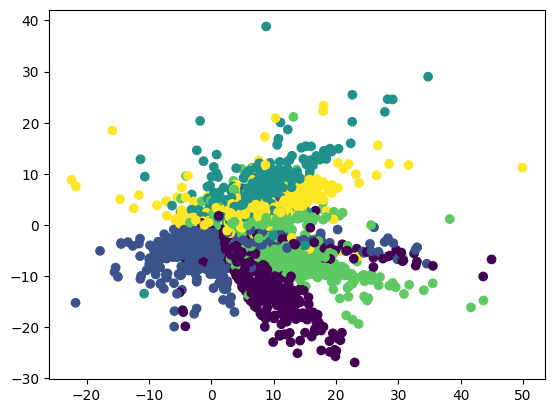

In [ ]:
#Plot for Autoencoder
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

QUESTION 23: In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with ground-truth labels. Describe your observation.

> Refer to the graphs above. We can see that t-SNE preserves more information as compared to PCA and hence it is a better choice for visualizing Vision features. t-SNE adopts a probabilistic approach and uses probability to group points such that two close points come from the same probability distribution. Whereas with PCA, it separates points far from each other on the basis of high variance. PCA is a linear dimensionality reduction technique. t-SNE is a non linear dimensionality reduction technique. Therefore t-SNE is generally preferred as it is more robust to outliers and preserves the local structure of the data.

# **Question 24**

In [ ]:
#Kmeans with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30).fit(f_all)
print("Kmeans Clustering Rand Score: ", rand_score(y_all, kmeans.labels_))

Kmeans Clustering Rand Score:  0.7038367707049935


In [ ]:
#Kmeans with 5 clusters + SVD with 50 n_components
svd = TruncatedSVD(n_components=50, random_state=0)
f_all_svd = svd.fit_transform(f_all)
kmeans_with_svd = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30).fit(f_all_svd)
print("SVD + Kmeans Clustering Rand Score: ",rand_score(y_all, kmeans_with_svd.labels_))

SVD + Kmeans Clustering Rand Score:  0.7047006252399699


In [ ]:
#Kmeans with 5 clusters + UMAP with n_components=50
umap_with_cosine_50 = umap.UMAP(n_components=50, metric='cosine').fit_transform(f_all)
kmeans_with_umap = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30).fit(umap_with_cosine_50)
print("UMAP + Kmeans Clustering Rand Score: ", rand_score(y_all, kmeans_with_umap.labels_))

UMAP + Kmeans Clustering Rand Score:  0.8225015094432104


In [ ]:
#Kmeans with 5 clusters + Autoencoder with num_features=50
autoencoder_val = Autoencoder(50).fit_transform(f_all)
kmeans_with_autoencoder = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30).fit(autoencoder_val)
print("Autoencoder + Kmeans Clustering Rand Score: ", rand_score(y_all, kmeans_with_autoencoder.labels_))

100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Autoencoder + Kmeans Clustering Rand Score:  0.7322016779512864


In [ ]:
#Agglomerative clustering with 5 clusters
agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(f_all)
print("Agglomerative Clustering Rand Score: ", rand_score(y_all, agg_clustering.labels_))

Agglomerative Clustering Rand Score:  0.7104411881564593


In [ ]:
#Agglomerative clustering with 5 clusters + SVD with n_components=50
svd = TruncatedSVD(n_components=50, random_state=0)
f_all_svd = svd.fit_transform(f_all)
agg_clustering_with_svd = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(f_all_svd)
print("SVD + Agglomerative Clustering Rand Score: ",rand_score(y_all, agg_clustering_with_svd.labels_))

SVD + Agglomerative Clustering Rand Score:  0.7063276304972139


In [ ]:
#Agglomerative clustering with 5 clusters + UMAP with n_components=50
umap_with_cosine_50 = umap.UMAP(n_components=50, metric='cosine').fit_transform(f_all)
agg_clustering_with_umap = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(umap_with_cosine_50)
print("UMAP + Agglomerative Clustering Rand Score: ",rand_score(y_all, agg_clustering_with_umap.labels_))

UMAP + Agglomerative Clustering Rand Score:  0.8189577155384646


In [ ]:
#Agglomerative clustering with 5 clusters + Autoencoder with num_features=50
autoencoder_val = Autoencoder(50).fit_transform(f_all)
agg_clustering_with_autoencoder = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30).fit(autoencoder_val)
print("Autoencoder + Agglomerative Clustering Rand Score: ", rand_score(y_all, agg_clustering_with_autoencoder.labels_))

100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Autoencoder + Agglomerative Clustering Rand Score:  0.7224684613630811


In [ ]:
#HDBSCAN with multiple min_cluster_size and min_samples
rand_score_list = []

minClusterSize = [5,10,50,100,500,1000]
minSamples = [5,10,20,50,100,200,500]
for i in range(len(minClusterSize)):
    for j in range(len(minSamples)):
        hdbs = hdbscan.HDBSCAN(min_cluster_size=minClusterSize[i],cluster_selection_epsilon=0.5,min_samples=minSamples[j],core_dist_n_jobs=-1).fit_predict(f_all)
        rand_score_list.append(rand_score(y_all, hdbs))


In [ ]:
#Finding the best values for min_cluster_size and min_samples
best_mcs_hdbscan = minClusterSize[rand_score_list.index(max(rand_score_list))//len(minSamples)]
best_ms_hdbscan = minSamples[rand_score_list.index(max(rand_score_list))%len(minSamples)]

In [ ]:
#Finding the rand_score
print('For HDBSCAN:')
print('Best value of minimum cluster size is:',best_mcs_hdbscan, ' and minimum number of samples is: ',best_ms_hdbscan)
print('Rand Score: ', max(rand_score_list))

For HDBSCAN:
Best value of minimum cluster size is: 5  and minimum number of samples is:  5
Rand Score:  0.4174787953863395


In [ ]:
#HDBSCAN + SVD with multiple min_cluster_size and min_samples
rand_score_list_svd = []

minClusterSize = [5,10,20,30,50,100,200,500,1000]
minSamples = [5,10,20,50,100,200,500]
for i in range(len(minClusterSize)):
    for j in range(len(minSamples)):
        hdbs = hdbscan.HDBSCAN(min_cluster_size=minClusterSize[i],cluster_selection_epsilon=0.5,min_samples=minSamples[j],core_dist_n_jobs=-1).fit_predict(f_all_svd)
        rand_score_list_svd.append(rand_score(y_all, hdbs))


In [ ]:
#Finding the best values for min_cluster_size and min_samples
best_mcs_hdbscan_svd = minClusterSize[rand_score_list_svd.index(max(rand_score_list_svd))//len(minSamples)]
best_ms_hdbscan_svd = minSamples[rand_score_list_svd.index(max(rand_score_list_svd))%len(minSamples)]

In [ ]:
#Finding the rand_score
print('For HDBSCAN with SVD:')
print('Best value of minimum cluster size is:',best_mcs_hdbscan_svd, ' and minimum number of samples is: ',best_ms_hdbscan_svd)
print('Rand Score: ', max(rand_score_list_svd))

For HDBSCAN with SVD:
Best value of minimum cluster size is: 10  and minimum number of samples is:  5
Rand Score:  0.43632466730980457


In [ ]:
#HDBSCAN + UMAP with multiple min_cluster_size and min_samples
rand_score_list_umap = []

minClusterSize = [5,10,20,30,50,100,200,500,1000]
minSamples = [5,10,20,50,100,200,500]
for i in range(len(minClusterSize)):
    for j in range(len(minSamples)):
        hdbs = hdbscan.HDBSCAN(min_cluster_size=minClusterSize[i],cluster_selection_epsilon=0.5,min_samples=minSamples[j],core_dist_n_jobs=-1).fit_predict(umap_with_cosine_50)
        rand_score_list_umap.append(rand_score(y_all, hdbs))


In [ ]:
#Finding the best values for min_cluster_size and min_samples
best_mcs_hdbscan_umap = minClusterSize[rand_score_list_umap.index(max(rand_score_list_umap))//len(minSamples)]
best_ms_hdbscan_umap = minSamples[rand_score_list_umap.index(max(rand_score_list_umap))%len(minSamples)]

In [ ]:
#Finding the rand_score
print('For HDBSCAN with UMAP:')
print('Best value of minimum cluster size is:',best_mcs_hdbscan_umap, ' and minimum number of samples is: ',best_ms_hdbscan_umap)
print('Rand Score: ', max(rand_score_list_umap))

For HDBSCAN with UMAP:
Best value of minimum cluster size is: 5  and minimum number of samples is:  10
Rand Score:  0.4572071921534203


In [ ]:
#HDBSCAN + Autoencoder with multiple min_cluster_size and min_samples
rand_score_list_autoencoder = []

minClusterSize = [5,10,20,30,50,100,200,500,1000]
minSamples = [5,10,20,50,100,200,500]
for i in range(len(minClusterSize)):
    for j in range(len(minSamples)):
        hdbs = hdbscan.HDBSCAN(min_cluster_size=minClusterSize[i],cluster_selection_epsilon=0.5,min_samples=minSamples[j],core_dist_n_jobs=-1).fit_predict(autoencoder_val)
        rand_score_list_autoencoder.append(rand_score(y_all, hdbs))


In [ ]:
#Finding the best values for min_cluster_size and min_samples
best_mcs_hdbscan_autoencoder = minClusterSize[rand_score_list_autoencoder.index(max(rand_score_list_autoencoder))//len(minSamples)]
best_ms_hdbscan_autoencoder = minSamples[rand_score_list_autoencoder.index(max(rand_score_list_autoencoder))%len(minSamples)]

In [ ]:
#Finding the rand_score
print('For HDBSCAN with Autoencoder:')
print('Best value of minimum cluster size is:',best_mcs_hdbscan_autoencoder, ' and minimum number of samples is: ',best_ms_hdbscan_autoencoder)
print('Rand Score: ', max(rand_score_list_autoencoder))

For HDBSCAN with Autoencoder:
Best value of minimum cluster size is: 10  and minimum number of samples is:  5
Rand Score:  0.42659947137924864


QUESTION 24: Report the best result (in terms of rand score) within the table below.
For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples.

>Kmeans:\
Kmeans Clustering Rand Score:  0.7038367707049935\
SVD + Kmeans Clustering Rand Score:  0.7047006252399699\
UMAP + Kmeans Clustering Rand Score:  0.8225015094432104\
Autoencoder + Kmeans Clustering Rand Score:  0.7322016779512864

>Agglomerative Clustering:\
Agglomerative Clustering Rand Score:  0.7104411881564593\
SVD + Agglomerative Clustering Rand Score:  0.7063276304972139\
UMAP + Agglomerative Clustering Rand Score:  0.81895771553846462\
Autoencoder + Agglomerative Clustering Rand Score:  0.7224684613630811

>HDBSCAN:\
For HDBSCAN:\
Best value of minimum cluster size is: 5  and minimum number of samples is:  5\
Rand Score:  0.4174787953863395\
For HDBSCAN with SVD:\
Best value of minimum cluster size is: 10  and minimum number of samples is:  5\
Rand Score:  0.43632466730980457\
For HDBSCAN with UMAP:\
Best value of minimum cluster size is: 5  and minimum number of samples is:  10\
Rand Score:  0.4572071921534203\
For HDBSCAN with Autoencoder:\
Best value of minimum cluster size is: 10  and minimum number of samples is:  5\
Rand Score:  0.42659947137924864

>We can see that Kmeans with UMAP performs the best from all with a rand score of 0.8225015094432104 followed by Agglomerative Clustering with UMAP with a rand score of 0.81895771553846462.



# **Question 25**

In [ ]:
#Class for MLP
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:

              optimizer.zero_grad()
              outputs = self(X_)

              loss = criterion(outputs, y_)
              loss.backward()
              optimizer.step()

        return self

    def eval(self, X_test, y_test):
        X = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        criterion = nn.NLLLoss()
        dataset = TensorDataset(X, y)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

        total = 0
        corr = 0

        with torch.no_grad():
          for (X,y) in dataloader :
            output = self.model(X)
            _,pred = torch.max(output,1)
            total += y.size(0)
            corr  += (pred==y).sum().item()

        accuracy = (corr/total)*100

        return accuracy

In [ ]:
#Splitting the dataset into train and test
X_train,X_test,y_train,y_test = train_test_split(f_all,y_all,test_size=0.2)

mlp = MLP(f_all.shape[1])
mlp.train(X_train,y_train)
mlp.eval(X_test,y_test)

100%|██████████| 100/100 [00:07<00:00, 13.46it/s]


91.41689373297002

In [ ]:
#MLP with SVD
svd = TruncatedSVD(n_components=50, random_state=0)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

mlp_svd = MLP(X_train_svd.shape[1])
mlp_svd.train(X_train_svd,y_train)
mlp_svd.eval(X_test_svd,y_test)

100%|██████████| 100/100 [00:06<00:00, 16.19it/s]


89.23705722070845

In [ ]:
#MLP with UMAP
umap = umap.UMAP(n_components=50, metric='cosine')
#Splitting the dataset into train and test
X_train_umap = umap.fit_transform(X_train)
X_test_umap = umap.transform(X_test)
mlp = MLP(X_train_umap.shape[1])
mlp.train(X_train_umap,y_train)
mlp.eval(X_test_umap,y_test)

100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


83.65122615803816

In [ ]:
#MLP with Autoencoder
autoencoder_val = Autoencoder(50)
X_train_autoencoder = autoencoder_val.fit_transform(X_train)
X_test_autoencoder = autoencoder_val.transform(X_test)

mlp = MLP(X_train_autoencoder.shape[1])
mlp.train(X_train_autoencoder,y_train)
mlp.eval(X_test_autoencoder,y_test)

100%|██████████| 100/100 [00:05<00:00, 17.75it/s]


84.46866485013625

QUESTION 25: Report the test accuracy of the MLP classifier on the original VGG features. Report the same when using the reduced-dimension features (you have freedom in choosing the dimensionality reduction algorithm and its parameters). Does the performance of the model suffer with the reduced-dimension representations? Is it significant? Does the success in classification make sense in the context of the clustering results obtained for the same features in Question 24.

>MLP Classifier on the original VGG features are as below:\
Test Accuracy without any dimensionality reduction - 91.41689373297002\
Test Accuracy with SVD - 89.23705722070845\
Test Accuracy with UMAP - 83.65122615803816\
Test Accuracy with autoencoder - 84.46866485013625\
We can see that MLP without any dimensionality reduction performs the best from all the above combinations. Without dimensionality reduction, the test accuracy is pretty close to that with SVD. For the remaining models, we can see a drop in test accuracy. For some it is a slight drop whereas for some it is more. The clusters in clustering models are formed on the basis of distance. But in MLP, the model learns the complex features and predicts the classes based on the learning. Therefore MLP is better than clustering.

